# Approach 1 Inference - CNN (Facial Image)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow import keras
import tensorflow as tf

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler,ReduceLROnPlateau

from tensorflow.keras import layers

import warnings
warnings.filterwarnings("ignore")

## Data Normalization

In [2]:
test_img_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [3]:
test_ds = test_img_datagen.flow_from_directory('dataset/images/test/', class_mode = 'categorical', batch_size=32, target_size=(48,48), color_mode='grayscale')

Found 1900 images belonging to 7 classes.


# Loading Saved Model for Inference

In [73]:
model = tf.keras.models.load_model('models/Model.h5')

In [74]:
model.evaluate(test_ds, verbose=1)

60/60 [==============================] - 1s 10ms/step - loss: 1.1565 - accuracy: 0.5711


[1.1565481424331665, 0.571052610874176]

In [75]:
pred = model.predict(test_ds)
pred = pred.round()

60/60 [==============================] - 1s 10ms/step


In [76]:
def extract_labels(iterator):
    labels = []
    for _, batch_labels in iterator:
        labels.append(batch_labels)
        if len(labels) * iterator.batch_size >= iterator.samples:
            break
    labels_array = np.concatenate(labels, axis=0)
    return labels_array

y_true = extract_labels(test_ds)

In [77]:
len(y_true), len(pred.round())

(1900, 1900)

In [78]:
from sklearn.metrics import classification_report

report = classification_report(y_true, pred, target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       angry       0.21      0.10      0.14       300
     disgust       0.06      0.01      0.02       100
        fear       0.15      0.03      0.05       300
       happy       0.14      0.12      0.13       300
     neutral       0.15      0.14      0.14       300
         sad       0.22      0.07      0.10       300
    surprise       0.18      0.14      0.16       300

   micro avg       0.17      0.10      0.12      1900
   macro avg       0.16      0.09      0.11      1900
weighted avg       0.17      0.10      0.11      1900
 samples avg       0.10      0.10      0.10      1900



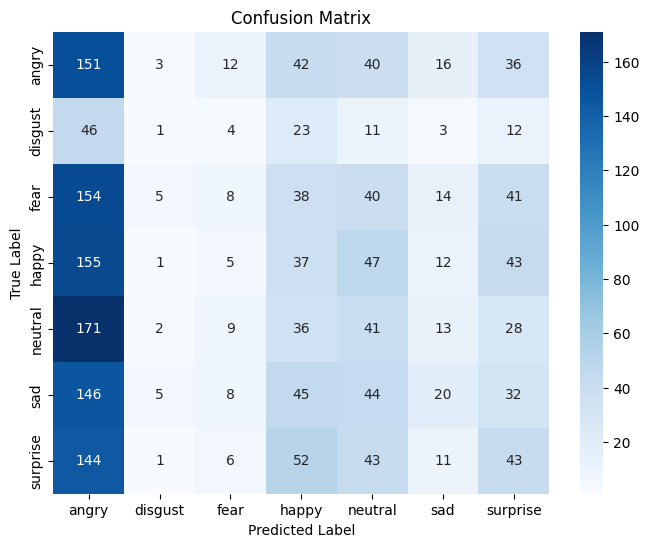

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true.argmax(axis=1), pred.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---

# Approach 2 Inference - CNN (Face with Landmark)

In [26]:
import pandas as pd
import glob
import numpy as np
import cv2

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import Sequence

from sklearn.preprocessing import StandardScaler

## Reading the Landmark CSV Files

In [27]:
path = "dataset/images/train"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
train_df = pd.concat(df_list, ignore_index=True)

path = "dataset/images/validation"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
valid_df = pd.concat(df_list, ignore_index=True)

path = "dataset/images/test"
all_files = glob.glob(path + "/*.csv")
df_list = [pd.read_csv(file) for file in all_files]
test_df = pd.concat(df_list, ignore_index=True)

print('Total Train : '+str(len(train_df)))
print('Total Validation : '+str(len(valid_df)))
print('Total Test : '+str(len(test_df)))

Total Train : 25343
Total Validation : 6649
Total Test : 1792


In [28]:
X_train = train_df.iloc[:, 2:].values
X_train_image = train_df.iloc[:, 0].values
y_train = train_df.iloc[:, 1].values

X_valid = valid_df.iloc[:, 2:].values
X_valid_image = valid_df.iloc[:, 0].values
y_valid = valid_df.iloc[:, 1].values

X_test = test_df.iloc[:, 2:].values
X_test_image = test_df.iloc[:, 0].values
y_test = test_df.iloc[:, 1].values

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_valid = label_encoder.fit_transform(y_valid)
y_test = label_encoder.fit_transform(y_test)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [29]:
expression_dict = {i: label for i, label in enumerate(label_encoder.classes_)}
print(expression_dict)

{0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6: 'surprise'}


In [36]:
def load_and_preprocess_image(file_path):
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (48, 48))
    image = image.astype('float32') / 255.0
    image = np.expand_dims(image, axis=-1)
    return image

## Data Generator

In [57]:
class DualInputDataGenerator(Sequence):
    def __init__(self, image_paths, landmarks, labels, path_directory='', batch_size=32, shuffle=True):
        self.image_paths = image_paths
        self.landmarks = landmarks
        self.labels = labels
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.path_directory = path_directory
        self.indices = np.arange(len(self.image_paths))
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.image_paths) / self.batch_size))

    def __getitem__(self, index):
        while True:
            indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
            image_paths_batch = self.image_paths[indices]
            landmarks_batch = self.landmarks[indices]
            labels_batch = self.labels[indices]
            
            if np.all(landmarks_batch != None):
                X_images = np.array([load_and_preprocess_image(f"{self.path_directory}/{expression_dict[label]}/{path}") for path, label in zip(image_paths_batch, labels_batch)])
                return [X_images, landmarks_batch], labels_batch
            
            self.on_epoch_end()
            index = np.random.randint(0, len(self))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

train_generator = DualInputDataGenerator(X_train_image, X_train, y_train, 'dataset/images/train/', 16)
val_generator = DualInputDataGenerator(X_valid_image, X_valid, y_valid, 'dataset/images/validation/', 16, shuffle=False)
test_generator = DualInputDataGenerator(X_test_image, X_test, y_test, 'dataset/images/test/', 16, shuffle=False)

(16, 48, 48, 1) (16, 1404)


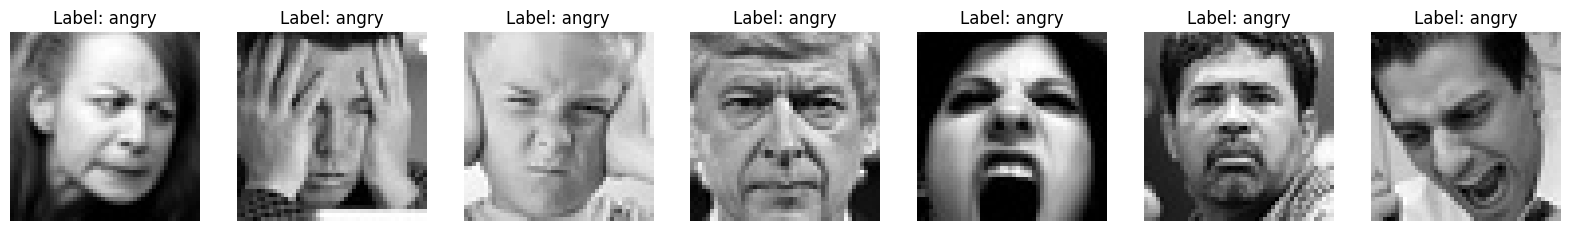

In [38]:
import matplotlib.pyplot as plt

def plot_images_from_generator(generator, num_images=7):
    data = next(iter(generator))
    images, landmarks = data[0]
    print(images.shape, landmarks.shape)
    labels = data[1]

    fig, axes = plt.subplots(1, num_images, figsize=(20, 4))
    for i in range(num_images):
        img = images[i].squeeze()
        landmark = landmarks[i]
        label = label_encoder.inverse_transform([labels[i]])[0]

        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.show()

plot_images_from_generator(val_generator)

# Loading Saved Model for Inference

In [39]:
model = tf.keras.models.load_model('models/dualInputModel.h5')

In [58]:
model.evaluate(test_generator, verbose=1)

112/112 [==============================] - 1s 5ms/step - loss: 1.4672 - accuracy: 0.4548


[1.467226266860962, 0.4547991156578064]

In [61]:
def predict_with_available_inputs(model, generator):
    all_predictions = []
    all_labels = []
    
    for batch_index in range(len(generator)):
        inputs, labels = generator[batch_index]
        X_images, landmarks_batch = inputs
        
        if np.all(landmarks_batch != None):
            predictions = model.predict([X_images, landmarks_batch])
            all_predictions.append(predictions)
            all_labels.append(labels)
    
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    return all_predictions, all_labels

In [62]:
pred, true = predict_with_available_inputs(model,test_generator)

1/1 [==============================] - 0s 13ms/step


In [63]:
len(true), len(pred.round())

(1792, 1792)

In [69]:
from sklearn.metrics import classification_report

report = classification_report(true, pred.argmax(axis=1), target_names=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

       angry       0.34      0.11      0.17       272
     disgust       0.00      0.00      0.00        86
        fear       0.33      0.18      0.23       282
       happy       0.61      0.78      0.69       295
     neutral       0.47      0.49      0.48       287
         sad       0.27      0.63      0.38       278
    surprise       0.81      0.64      0.71       292

    accuracy                           0.45      1792
   macro avg       0.41      0.41      0.38      1792
weighted avg       0.45      0.45      0.43      1792



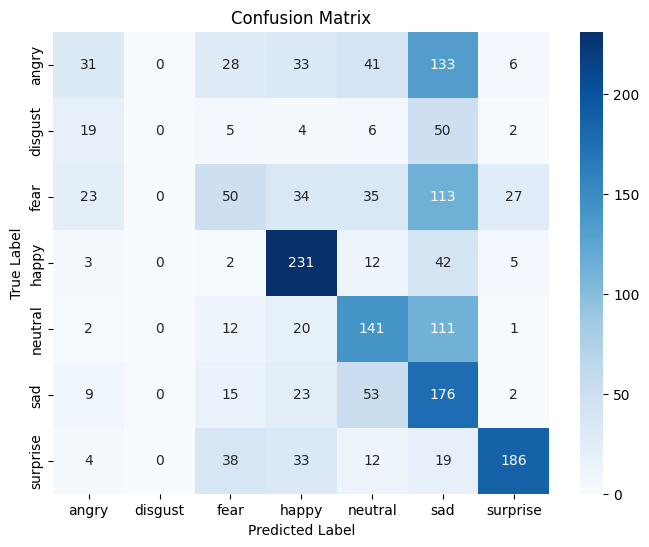

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, pred.argmax(axis=1))

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'], yticklabels=['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---